# <font color='blue'>Data Science Academy - Projeto Especial 1</font>
# <font color='blue'>Segmentação de Imagens Médicas com Deep Learning</font>
# <font color='blue'>Modelo de Rede Neural Convolucional</font>

In [ ]:
# Imports
import cv2
import keras
import dicom
import json
import glob
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.losses import mean_squared_error
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline

O primeiro passo do algoritmo é localizar o Ventriculo Esquerdo e calcular as Regiões de Interesse (ROI) em torno dele. Queremos recriar a rede neural convolutiva para esta detecção automática. Esta CNN vai gerar máscara binária com o ROI.

A primeira parte é abrir o conjunto de dados (imagens com o respectivo contorno ao redor do ventrículo esquerdo) e gerar o ROI da máscara binária (imagem com fundo preto e um primeiro plano branco correspondente ao ROI) a partir dos dados rotulados (contornos desenhados por especialistas), como é o resultado da CNN.
A segunda parte é o modelo CNN e o treinamento.

## Abrindo o dataset

In [2]:
def get_roi(image, contour, shape_out = 32):
    """
    Cria uma máscara binária com ROI a partir do contorno. Extrai o quadrado máximo ao redor do contorno.
    :param image: input image (needed for shape only)
    :param contour: numpy array contour (d, 2)
    :return: numpy array mask ROI (shape_out, shape_out)
    """
    X_min, Y_min = contour[:,0].min(), contour[:,1].min()
    X_max, Y_max = contour[:,0].max(), contour[:,1].max()  
    w = X_max - X_min
    h = Y_max - Y_min
    mask_roi = np.zeros(image.shape)
    if w > h :
        mask_roi[int(Y_min - (w -h)/2):int(Y_max + (w -h)/2), int(X_min):int(X_max)] = 1.0
    else :
        mask_roi[int(Y_min):int(Y_max), int(X_min - (h-w)/2):int(X_max + (h -w)/2)] = 1.0
    return cv2.resize(mask_roi, (shape_out, shape_out), interpolation = cv2.INTER_NEAREST)

In [12]:
X, X_fullsize, Y, contour_mask = create_dataset(n_set='train')

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


In [10]:
def create_dataset(image_shape=64, n_set='train', original_image_shape=256, roi_shape=32, data_path='./Data/'):
    """
    Criando o conjunto de dados das imagens e do contorno para a CNN.
    :param image_shape: image dataset desired size
    :param original_image_shape: original image size
    :param roi_shape: binary ROI mask shape
    :param data_path: path for the dataset
    :return: correct size image dataset, full size image dataset, label (contours) dataset
    """
    
    if n_set == 'train':
        number_set = 3
        name_set = 'Training'
    elif n_set == 'test':
        number_set = 1
        name_set = 'Online'         
    
    # Create dataset
    series = json.load(open('series_case.json'))[n_set]
    images, images_fullsize, contours, contour_mask = [], [], [], []
    
    # Loop over the series
    for case, serie in series.items():
        image_path_base = data_path + 'challenge_%s/%s/IM-%s' % (name_set.lower(),case, serie)
        contour_path_base = data_path + 'Sunnybrook Cardiac MR Database ContoursPart%s/\
%sDataContours/%s/contours-manual/IRCCI-expert/' % (number_set, name_set, case)
        contours_list = glob.glob(contour_path_base + '*')
        contours_list_series = [k.split('/')[7].split('-')[2] for k in contours_list]
        
        # Loop over the contours/images
        for c in contours_list_series:
            
            # Get contours and images path
            idx_contour = contours_list_series.index(c)
            image_path = image_path_base + '-%s.dcm' % c
            contour_path = contours_list[idx_contour]

            # open image as numpy array and resize to (image_shape, image_shape)
            image_part = dicom.read_file(image_path).pixel_array  

            # open contours as numpy array
            contour = []
            file = open(contour_path, 'r') 
            for line in file: 
                contour.append(tuple(map(float, line.split())))
            contour = np.array(contour)
            
            # append binary ROI mask 
            contours.append(get_roi(image_part, contour))

            # create mask contour with experts contours
            x, y = np.meshgrid(np.arange(256), np.arange(256)) # make a canvas with coordinates
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T 
            p = Path(contour) # make a polygon
            grid = p.contains_points(points)
            mask_contour = grid.reshape(256,256)
            mask_contour=mask_contour*1
            contour_mask.append(mask_contour)
            
            # Open image and resize it 
            images.append(cv2.resize(image_part, (image_shape, image_shape)))
            images_fullsize.append(cv2.resize(image_part, (original_image_shape, original_image_shape)))
    X_fullsize = np.array(images_fullsize)
    X = np.reshape(np.array(images), [len(images), image_shape, image_shape, 1])
    Y = np.reshape(np.array(contours), [len(contours), 1, roi_shape, roi_shape])
    print('Dataset shape :', X.shape, Y.shape)
    return X, X_fullsize, Y, contour_mask

Para o input, o tamanho original da imagem de $256\times256$ foi reduzido para $64\times64$. A máscara ROI binária (usada como rótulos) tem um tamanho de $32\times32$ (como a máscara de saída CNN). O primeiro plano branco da máscara binária está centrado no centro do contorno do ventrículo esquerdo (conhecido pelos contornos do manual de treinamento).

In [4]:
X, X_fullsize, Y, contour_mask = create_dataset()

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


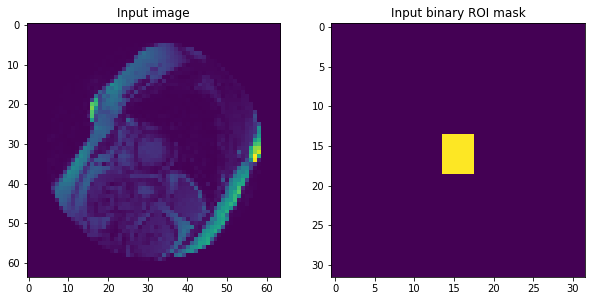

In [5]:
f, ax = plt.subplots(ncols = 2, figsize=(10,10))
ax[0].imshow(X[30].reshape(64,64))
ax[0].set_title('Input image')
ax[1].imshow(Y[30].reshape(32, 32))
_ = ax[1].set_title('Input binary ROI mask')

## Criando o Modelo

### Modelo

In [6]:
def create_model(input_shape=(64, 64)):
    """
    Modelo de convnet simples: uma convolução, um averaging pooling e uma camada totalmente conectada:
    :return: Keras model
    """
    model = Sequential()
    model.add(Conv2D(100, (11,11), padding='valid', strides=(1, 1), input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(AveragePooling2D((6,6)))
    model.add(Reshape([-1, 8100]))
    model.add(Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Reshape([-1, 32, 32]))
    return model

In [7]:
m = create_model()
m.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print('Size for each layer :\nLayer, Input Size, Output Size')
for p in m.layers:
    print(p.name.title(), p.input_shape, p.output_shape)

Size for each layer :
Layer, Input Size, Output Size
Conv2D_1 (None, 64, 64, 1) (None, 54, 54, 100)
Average_Pooling2D_1 (None, 54, 54, 100) (None, 9, 9, 100)
Reshape_1 (None, 9, 9, 100) (None, 1, 8100)
Dense_1 (None, 1, 8100) (None, 1, 1024)
Reshape_2 (None, 1, 1024) (None, 1, 32, 32)


### Treinamento

Treinar a CNN envolve a obtenção dos melhores valores de filtros. No paper, eles estão usando um autoencoder esparso que atua em um passo de pré-treinamento porque o número de treinamento e os dados rotulados são limitados. A tarefa de um autoencoder é construir $ x ^ {(i)} $ na saída dos valores ocultos. Não implementamos este autoencoder esparso. Podemos tentar o aumento de dados: o número de treinamento e os dados rotulados são limitados para que possamos tentar usar o aumento de dados para gerar nova imagem do nosso conjunto de treinamento. Com a biblioteca Keras, podemos aplicar transformações em nossas fotos de treinamento para gerar imagens "novas".

In [8]:
def training(m, X, Y, batch_size=16, epochs= 10, data_augm=False):
    """
    Treinando CNN com a possibilidade de usar o aumento de dados
    :param m: Keras model
    :param X: training pictures
    :param Y: training binary ROI mask
    :return: history
    """
    if data_augm:
        datagen = ImageDataGenerator(
            featurewise_center=False,             # set input mean to 0 over the dataset
            samplewise_center=False,              # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,   # divide each input by its std
            zca_whitening=False,                  # ZCA whitening
            rotation_range=50,                    # rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,                # shift images horizontally (fraction of total width)
            height_shift_range=0.1,               # shift images vertically (fraction of total height)
            horizontal_flip=True,                 # flip images
            vertical_flip=False) 
        datagen.fit(X)
        history = m.fit_generator(datagen.flow(X, Y,
                                    batch_size=batch_size),
                                    steps_per_epoch=X.shape[0] // batch_size,
                                    epochs=epochs)         
    else:
        history = m.fit(X, Y, batch_size=batch_size, epochs=epochs)
    return history

In [9]:
h = training(m, X, Y, batch_size=16, epochs= 20, data_augm=False)

Epoch 1/20
495/495 [==============================] - 5s 11ms/step - loss: 0.1845 - acc: 0.1955
Epoch 2/20
495/495 [==============================] - 5s 10ms/step - loss: 0.1044 - acc: 0.1415
Epoch 3/20
495/495 [==============================] - 5s 10ms/step - loss: 0.0782 - acc: 0.0820
Epoch 4/20
495/495 [==============================] - 6s 11ms/step - loss: 0.0632 - acc: 0.0460
Epoch 5/20
495/495 [==============================] - 5s 11ms/step - loss: 0.0539 - acc: 0.0403
Epoch 6/20
495/495 [==============================] - 6s 11ms/step - loss: 0.0480 - acc: 0.0490
Epoch 7/20
495/495 [==============================] - 5s 10ms/step - loss: 0.0425 - acc: 0.0562
Epoch 8/20
495/495 [==============================] - 5s 10ms/step - loss: 0.0394 - acc: 0.0598
Epoch 9/20
495/495 [==============================] - 5s 10ms/step - loss: 0.0374 - acc: 0.0674
Epoch 10/20
495/495 [==============================] - 5s 10ms/step - loss: 0.0353 - acc: 0.0506
Epoch 11/20
495/495 [==================

Text(0.5,1,'Learning curve')

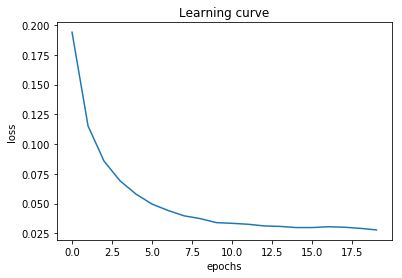

In [14]:
metric = 'loss'
plt.plot(range(len(h.history[metric])), h.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')
plt.title("Learning curve")

O tamanho original da imagem MR é $256\times256$. Portanto, a máscara de saída é selecionada a partir de $32\times32$ para este tamanho MR original. O centro da máscara é então calculado e usado para cortar um ROI de tamanho $100\times100$ a partir da imagem original para posterior processamento na próxima etapa (Stacked AE).

### Previsões e cálculos para o próximo estágio

In [15]:
y_pred = m.predict(X, batch_size=16)
%store y_pred

Stored 'y_pred' (ndarray)


In [28]:
def compute_roi_pred(y_pred, idx, roi_shape=32):
    """
    Computação e corte de um ROI a partir da imagem original para posterior processamento na próxima etapa
    :param y_pred: predictions
    :param idx: desired image prediction index
    :param roi_shape: shape of the binary mask
    """
    # up sampling from 32x32 to original MR size
    pred = cv2.resize(y_pred[idx].reshape((roi_shape, roi_shape)), (256,256), cv2.INTER_NEAREST)
    
    # Pixels não nulos
    pos_pred = np.array(np.where(pred > 0.5))
    
    # get the center of the mask
    X_min, Y_min = pos_pred[0, :].min(), pos_pred[1, :].min()
    X_max, Y_max = pos_pred[0, :].max(), pos_pred[1, :].max()  
    X_middle = X_min + (X_max - X_min) / 2
    Y_middle = Y_min + (Y_max - Y_min) / 2
    
    # Coordenadas do ROI
    X_top = int(X_middle - 50)
    Y_top = int(Y_middle - 50)
    X_down = int(X_middle + 50)
    Y_down = int(Y_middle + 50)
    
    # Crop ROI size 100x100
    mask_roi = np.zeros((256, 256))
    mask_roi = cv2.rectangle(mask_roi, (X_top, Y_top), (X_down, Y_down), 1, -1)*255
    return X_fullsize[idx][X_top:X_down, Y_top:Y_down], mask_roi, contour_mask[idx][X_top:X_down, Y_top:Y_down]

In [29]:
pred2, mask_roi, mask_contour = compute_roi_pred(y_pred, 234)

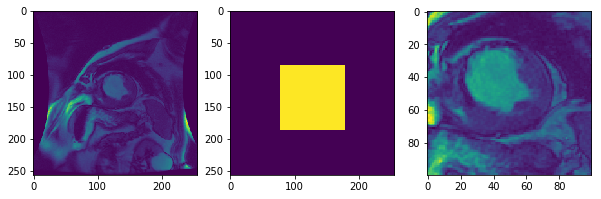

In [19]:
f, ax = plt.subplots(ncols=3, figsize=(10,10))
ax[0].imshow(X_fullsize[234])
ax[1].imshow(mask_roi)
ax[2].imshow(pred2)

In [19]:
cv2.imwrite('Resultado/images/mask_roi.png', mask_roi)
cv2.imwrite('Resultado/images/predic_roi.png', pred2)

True

(<matplotlib.image.AxesImage at 0x1251b86a0>, (100, 100))

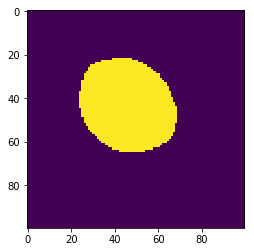

In [31]:
plt.imshow(mask_contour), mask_contour.shape

# Fim